# Task

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

# Additional links

[The list of libraries for detected language](https://stackoverflow.com/questions/39142778/how-to-determine-the-language-of-a-piece-of-text)

# Libraries and fanctions

## Install libraries

In [1]:
!pip install pymorphy2 clean-text dill langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 79.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.8 MB/s eta 0:00:00
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=f3bb088a74ca6ed2705ab4262da5c86a09c1433db2cce10ef170bc3dc4da79df
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=619137f8df112e84d4800337a5418f1b227cb848ec43fe

## Import libraries

In [2]:
import os
import shutil
import time
import re
from google.colab import drive, files
import pandas as pd
import numpy as np
from tqdm import tqdm
import dill
from pymorphy2 import MorphAnalyzer
from cleantext import clean
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchtext
from torchtext import transforms
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import nltk
from nltk.corpus import stopwords
import langid
import emoji
tqdm.pandas()
import matplotlib.pyplot as plt
from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and

## Additional functions

## For NLTK

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('names')
nltk.download('tagsets')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

## My functions

In [4]:
def MDir(dir_name):
    """Make a new folder"""
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


def Upload(dir_name):
    """Upload files from PC to work dir"""
    f = files.upload()
    for fl in list(f.keys()):
        shutil.move('/content/' + fl, dir_name + fl)


def label_to_categorical(df:pd.DataFrame, key:str):
    res = np.zeros((df[key].shape[0], df[key].value_counts().index.max()), dtype=int)
    res[np.arange(df[key].shape[0]), df[key]-1] = 1
    return res.tolist()


class CleanText(BaseEstimator, TransformerMixin):

    """Cleaning text from regular characters in column
    key: str - name of column default:None
        If key = None then X in transform must be str
    stp_wrd: str - english, russian, ... default:english
    like_list: bool - True|False default:False
        If True then return text as list [word, word, ..., word], False return str,
        default False
    my_fun: Any default:None

    You shoul to import:
        >>> pip install pymorphy2
        >>> pip install clean-text
        import re
        import pandas as pd
        from tqdm import tqdm
        from pymorphy2 import MorphAnalyzer
        from sklearn.base import BaseEstimator, TransformerMixin
        from cleantext import clean
        imort emoji
        from nltk.corpus import stopwords
        nltk.download('stopwords')"""

    def __init__(self, key:str=None, stp_wrd:str=None, my_fun=None, like_list:bool = False):
        self.key = key
        if stp_wrd == None:
            self.stp_wrd = "english"
        else:
            self.stp_wrd = stp_wrd
        self.sw = stopwords.words(self.stp_wrd)
        self.morpher = MorphAnalyzer()
        self.like_list = like_list
        self.my_fun = my_fun


    def clean_text(self, text:str) -> str:

        """Clean text"""

        if not isinstance(text, str):
            text = str(text)

        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        if self.stp_wrd == 'russian':
            text = re.sub(r'https?://\S+|www\.\S+', "электронныйадресс", text)
        else:
            text = re.sub(r'https?://\S+|www\.\S+', "weblinks", text)

        text = re.sub("\s\r\n\|-\s\r\n|\r\n", '', str(text))
        text = emoji.replace_emoji(text, '')
        text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub("\s\w\s", " ", text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
        text = re.sub('\n', ' ', text)
        text = [self.morpher.parse(word)[0].normal_form for word in text.split() if word not in self.sw]
        if self.like_list:
            return text
        else:
            text = " ".join(text)
            return text

    def get_feature_names_out(self, feature_names_out=None):
        if feature_names_out != None:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X) -> pd.DataFrame:
        if isinstance(X, pd.DataFrame):
            tqdm.pandas()
            if self.my_fun:
                X[self.key] = X[self.key].progress_apply(lambda x: self.my_fun(x))
            else:
                X[self.key] = X[self.key].progress_apply(lambda x: self.clean_text(x))
            return X[self.key]
        else:
            if self.my_fun:
                X = self.my_fun(X)
            else:
                X = self.clean_text(X)
            return X


class Preprocessing_data():

    """Cleaning text from regular characters and
    transformations text to sequence
    *X - X_train, X_val, X_test
    cln_txt_key : str - column name
    tfidf_params : dict - Params for TfidfVectorizer"""

    def __init__(self, *X, cln_txt_key:str = None, tfidf_params:dict = None):
        self.tfidf = TfidfVectorizer(**tfidf_params)
        self.key = cln_txt_key
        self.cln_txt = CleanText(key=self.key)
        self.X = list(X)
        len_x = len(self.X)
        pad = [[None]] * (3-len_x)
        self.X = self.X[-len_x:] + pad
        self.X_train, self.X_val, self.X_test = self.X

    def data_preprocessing(self, clntxt = True):
        if clntxt:
            self.X_train = self.cln_txt.transform(self.X_train)
            self.X_val = self.cln_txt.transform(self.X_val)
            self.X_test = self.cln_txt.transform(self.X_test)
            self.vocab = self.tfidf.fit(self.X_train).vocabulary_
        else:
            self.X_train = self.X_train[self.key]
            self.X_val = self.X_val[self.key]
            self.X_test = self.X_test[self.key]
            self.vocab = self.tfidf.fit(self.X_train).vocabulary_
        return self.vocab

    def text_to_sequence(self, text, maxlen) -> list:
        result = []
        tokeniz = self.tfidf.build_tokenizer()
        tokens_list = tokeniz(text)
        for word in tokens_list:
            if word in self.vocab:
                result.append(self.vocab[word])

        padding = [0] * (maxlen-len(result))
        return result[-maxlen:] + padding

    def results(self, max_len:int=25) -> np.array:
        x_train = np.asarray([self.text_to_sequence(text, max_len) for text in self.X_train])
        x_val = np.asarray([self.text_to_sequence(text, max_len) for text in self.X_val])
        x_test = np.asarray([self.text_to_sequence(text, max_len) for text in self.X_test])
        return x_train, x_val, x_test


class MyTextData(Dataset):
    def __init__(self, data, target, transform=None):
        if isinstance(data, np.ndarray):
            self.data = torch.from_numpy(data).long()
        else:
            self.data = torch.tensor(data).long()
        if isinstance(target, np.ndarray):
            self.target = torch.from_numpy(target).long()
        else:
            self.target = torch.tensor(target, dtype=torch.float64)
        self.transform = transform

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)


class Model_Text(nn.Module):
    def __init__(self, vocab_size, embedding_out, out_channel):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_out)
        self.conv_1d_1 = nn.Conv1d(embedding_out, embedding_out // 2, kernel_size=3)
        self.conv_1d_2 = nn.Conv1d(embedding_out // 2, embedding_out // 4, kernel_size=3)
        self.global_1d_1 = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embedding_out // 4, embedding_out // 8)
        self.fc2 = nn.Linear(embedding_out // 8, embedding_out // 16)
        self.fc3 = nn.Linear(embedding_out // 16, out_channel)


    def forward(self, x):
        out_e = self.embedding(x)
        out_e = out_e.permute(0,2,1)
        out_conv = self.conv_1d_1(out_e)
        out_conv = self.conv_1d_2(out_conv)
        out_pool = self.global_1d_1(out_conv)
        out_pool = out_pool.permute(0,2,1)
        out_fc1 = self.fc1(out_pool)
        out_fc2 = self.fc2(out_fc1)
        out_fc3 = self.fc3(out_fc2)
        output = F.relu(out_fc3)
        return output


def NN_Model_Fit(model, epoch, dev, train_loader, val_loader, optimizer, criterion):

    """
    model : model
    epoch : int
    dev : device
    threshold : float
    train_loader : <class 'torch.utils.data.dataloader.DataLoader'>
    val_loader : <class 'torch.utils.data.dataloader.DataLoader'>
    optimizer : torch.optim....
    criterion : torch.nn.modules.loss....
    """

    epochs = epoch
    M = model.to(dev)
    M.train()

    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    start = time.time()

    for epoch in range(epochs):
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 1):
            inputs, labels = data[0].to(dev), data[1].to(dev)

            # обнуляем градиент
            optimizer.zero_grad()
            # Предсказание
            outputs = M(inputs)
            # Расчет функции потерь
            outputs = outputs.reshape(outputs.size()[0], outputs.size()[2])
            loss = criterion(outputs, labels)
            # Обратный шаг по функции потерь
            loss.backward()
            # Шаг оптимизатора
            optimizer.step()

            # подсчет ошибки на обучении
            running_loss += loss.item()
            running_items += len(labels)
            # подсчет метрики на обучении
            # print(labels.size(), outputs.size())
            # running_right += (labels == outputs).sum()
            # running_right += (labels == outputs)

        # выводим статистику о процессе обучения
        M.eval()

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                f'Step [{i + 1}/{len(train_loader)}]. ' \
                f'Loss: {running_loss / running_items:.5f}. ', end='. ')
        # train_acc = running_right / running_items
        train_loss = running_loss / running_items
        # train_acc_history.append(train_acc.item())
        train_loss_history.append(train_loss)

            # выводим статистику на тестовых данных
        test_running_right, test_running_items, test_running_loss = 0.0, 0.0, 0.0
        for data in val_loader:
            test_labels = data[1].to(dev)
            test_outputs = M(data[0].to(dev))

            # подсчет ошибки на тесте
            test_outputs = test_outputs.reshape(test_outputs.size()[0], test_outputs.size()[2])
            loss_test = criterion(test_outputs, test_labels)
            test_running_loss += loss_test.item()
            # подсчет метрики на тесте
            test_running_items += len(test_labels)
            # test_running_right += (test_labels == torch.max(test_outputs, 1)[1]).sum()

            # test_acc = test_running_right / test_running_items
            test_loss = test_running_loss / test_running_items

        test_loss_history.append(test_loss)
        # test_acc_history.append(test_acc.item())
        print(f'Test Loss: {test_running_loss / test_running_items:.5f}.')

        M.train()

    stop = time.time()
    print(f'\nTraining is finished! It took {round((stop - start), 2)} seconds')
    return {'train_loss' : train_loss_history,
            # 'train_acc' : train_acc_history,
            'test_loss' : test_loss_history,
            # 'test_acc' : test_acc_history
            }


def save_model_dill(path, model_name):
    with open(path, "wb") as mod:
        dill.dump(model_name, mod)

def load_model_dill(path):
    with open(path, "rb") as mod1:
        model_name = dill.load(mod1)
    return model_name

def save_model_pkl(path, model_name):
    with open(path, "wb") as mod:
        pickle.dump(model_name, mod)

def load_model_pkl(path):
    with open(path, "rb") as mod1:
        model_name = pickle.load(mod1)
    return model_name

In [5]:
path_to_work_dir = "/content/drive/MyDrive/NLP_HW7/"

In [6]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# MDir(path_to_work_dir)

In [8]:
# Upload(path_to_work_dir)

# About data

## Load data

In [ ]:
df = pd.read_excel(path_to_work_dir + 'отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


## Review data

In [ ]:
df.shape

(20659, 3)

In [ ]:
df['Rating'].value_counts()

Rating
5    14586
1     2276
4     2138
3      911
2      748
Name: count, dtype: int64

## Preprocising data

### Get a type of data content

In [ ]:
df['Type_c'] = df['Content'].progress_apply(lambda x: type(x))

100%|██████████| 20659/20659 [00:00<00:00, 664642.65it/s]


### Remove nan in Content

In [ ]:
df.loc[(df['Content'].isna() == True) & (df['Rating'] == 5), ['Content']] = 'Отлично'
df.loc[(df['Content'].isna() == True) & (df['Rating'] == 4), ['Content']] = 'Хорошо'

In [ ]:
df.isna().sum()

Rating     0
Content    0
Date       0
Type_c     0
dtype: int64

In [ ]:
df.loc[(df['Type_c'] == int) & (df['Rating'] == 5), ['Content']] = 'Отлично'

### Get a type of language content

In [ ]:
df['Lang_c'] = df['Content'].progress_apply(lambda x: langid.classify(x)[0])

100%|██████████| 20659/20659 [00:44<00:00, 462.95it/s]


In [ ]:
df.to_csv(path_to_work_dir + 'Reviews.csv', index=None)

In [ ]:
df = pd.read_csv(path_to_work_dir + 'Reviews.csv')
df.head()

,Rating,Content,Date,Type_c,Lang_c
0,5,It just works!,2017-08-14,<class 'str'>,en
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,<class 'str'>,ru
2,5,Отлично все,2017-08-14,<class 'str'>,bg
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,<class 'str'>,ru
4,5,"Очень удобно, работает быстро.",2017-08-14,<class 'str'>,ru


### Review type of language content

In [ ]:
df['Lang_c'].value_counts()

Lang_c
ru    15678
bg     2309
sr      880
uk      418
mk      355
be      282
en      241
kk      229
hr       61
mn       60
zh       50
ja       20
de       18
am        8
es        5
fr        4
vi        3
pl        3
bs        3
fi        2
ml        2
hy        2
ko        2
fa        2
he        2
ky        2
it        2
qu        2
ne        1
lt        1
mr        1
sl        1
pt        1
et        1
xh        1
gl        1
pa        1
sv        1
nl        1
da        1
mt        1
km        1
Name: count, dtype: int64

In [ ]:
percent_other_lang = df.loc[df['Lang_c'] != 'ru', ['Lang_c']].count()[0] / df.loc[df['Lang_c'] == 'ru', ['Lang_c']].count()[0]

In [ ]:
print(f'Percent ru lang = {(1-percent_other_lang) * 100:.3f} %')

Percent ru lang = 68.229 %


I will leave only 68 percent of the data to speed up the learning process.

In [ ]:
df_rus = df[df['Lang_c'] == 'ru']
df_rus.shape

(15678, 5)

In [ ]:
df_rus.to_csv(path_to_work_dir + 'RuReviews.csv', index=None)

### Transformation rating to categorical

In [9]:
df = pd.read_csv(path_to_work_dir + 'RuReviews.csv')
df.head()

,Rating,Content,Date,Type_c,Lang_c
0,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,<class 'str'>,ru
1,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,<class 'str'>,ru
2,5,"Очень удобно, работает быстро.",2017-08-14,<class 'str'>,ru
3,5,Всё удобно норм 👍👍👍,2017-08-14,<class 'str'>,ru
4,5,Очень удобное приложение.,2017-08-14,<class 'str'>,ru


In [10]:
df['Rating'] = label_to_categorical(df, 'Rating')

In [11]:
df.head()

,Rating,Content,Date,Type_c,Lang_c
0,"[0, 0, 0, 1, 0]",В целом удобноное приложение...из минусов хотя...,2017-08-14,<class 'str'>,ru
1,"[0, 0, 0, 0, 1]",Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,<class 'str'>,ru
2,"[0, 0, 0, 0, 1]","Очень удобно, работает быстро.",2017-08-14,<class 'str'>,ru
3,"[0, 0, 0, 0, 1]",Всё удобно норм 👍👍👍,2017-08-14,<class 'str'>,ru
4,"[0, 0, 0, 0, 1]",Очень удобное приложение.,2017-08-14,<class 'str'>,ru


In [12]:
# df.to_csv(path_to_work_dir + 'Reviews_rating_to_vec.csv', index=None)

In [13]:
# df = pd.read_csv(path_to_work_dir + 'Reviews_rating_to_vec.csv')
# df.head(7)

### Split data

In [14]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)

In [15]:
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((9328, 5), (3998, 5), (2352, 5))

### Vectorizer params

In [17]:
vectorizer_params = {
    "TfidfVectorizer" : {
        "analyzer": "word",
        "max_features": 3500,
        "ngram_range": (1, 1)
    }
}

In [18]:
vect_param = vectorizer_params['TfidfVectorizer']

In [19]:
P = Preprocessing_data(df_train, df_val, df_test, cln_txt_key='Content', tfidf_params=vect_param)

In [20]:
vocab_ner = P.data_preprocessing()

  0%|          | 0/9328 [00:00<?, ?it/s]<ipython-input-4-787c16f339e2>:73: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|██████████| 2352/2352 [00:03<00:00, 642.88it/s]


In [21]:
x_train, x_val, x_test = P.results(40)

In [22]:
x_train.shape, x_val.shape, x_test.shape

((9328, 40), (3998, 40), (2352, 40))

# Model

## Create dataloader

In [50]:
batch_size_train = 512
train_dataset = MyTextData(x_train, df_train['Rating'].values.tolist())
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

batch_size_val = 16
val_dataset = MyTextData(x_val, df_val['Rating'].values.tolist())
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

In [51]:
max_words = vect_param['max_features']
max_words

3500

## Create model

In [52]:
model = Model_Text(max_words, 1024, out_channel=5)

In [53]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Model_Text(
  (embedding): Embedding(3500, 1024)
  (conv_1d_1): Conv1d(1024, 512, kernel_size=(3,), stride=(1,))
  (conv_1d_2): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
  (global_1d_1): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)
Parameters: 5592325


In [54]:
# model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
model_loss = nn.CrossEntropyLoss()

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Learn model

In [56]:
results = NN_Model_Fit(model, 20, device, train_loader, val_loader, model_optimizer, model_loss)

Epoch [1/20]. Step [20/19]. Loss: 0.00298. . Test Loss: 0.08465.
Epoch [2/20]. Step [20/19]. Loss: 0.00259. . Test Loss: 0.07468.
Epoch [3/20]. Step [20/19]. Loss: 0.00231. . Test Loss: 0.06813.
Epoch [4/20]. Step [20/19]. Loss: 0.00215. . Test Loss: 0.06513.
Epoch [5/20]. Step [20/19]. Loss: 0.00209. . Test Loss: 0.06407.
Epoch [6/20]. Step [20/19]. Loss: 0.00207. . Test Loss: 0.06376.
Epoch [7/20]. Step [20/19]. Loss: 0.00204. . Test Loss: 0.06367.
Epoch [8/20]. Step [20/19]. Loss: 0.00206. . Test Loss: 0.06359.
Epoch [9/20]. Step [20/19]. Loss: 0.00206. . Test Loss: 0.06356.
Epoch [10/20]. Step [20/19]. Loss: 0.00205. . Test Loss: 0.06352.
Epoch [11/20]. Step [20/19]. Loss: 0.00204. . Test Loss: 0.06351.
Epoch [12/20]. Step [20/19]. Loss: 0.00206. . Test Loss: 0.06348.
Epoch [13/20]. Step [20/19]. Loss: 0.00205. . Test Loss: 0.06345.
Epoch [14/20]. Step [20/19]. Loss: 0.00204. . Test Loss: 0.06344.
Epoch [15/20]. Step [20/19]. Loss: 0.00204. . Test Loss: 0.06342.
Epoch [16/20]. Step

## Visualisation of loss history

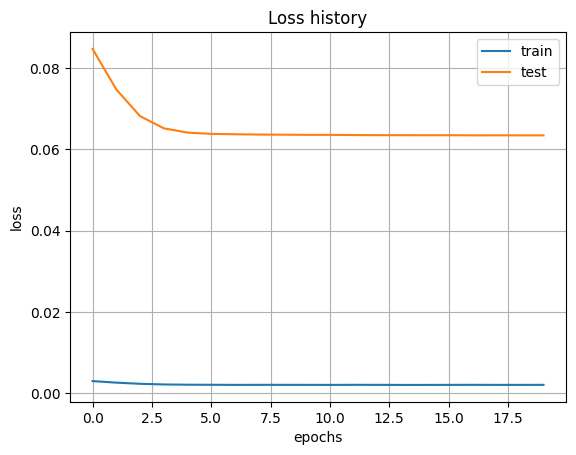

In [57]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.legend()
plt.show()

![Optimizers](https://habrastorage.org/webt/7p/jc/io/7pjcio1qukwjemezhhmznme7zre.gif)

In [58]:
x_test_1 = torch.from_numpy(x_test).to(device)

In [59]:
y_pred = model(x_test_1)

In [60]:
y_pred = y_pred.cpu().detach().numpy().reshape(y_pred.shape[0], y_pred.shape[2])

In [61]:
TP = 0
FN = 0
for y in range(len(y_pred)):
    if y_pred[y].argmax() == list(df_test['Rating'].iloc[y]).index(1):
        TP += 1
    else:
        FN += 1

In [62]:
print(TP, FN)

1547 805


In [63]:
print(f'Accuracy = {TP / (TP + FN) * 100:.3f} %')

Accuracy = 65.774 %


## Save model

In [64]:
torch.save(model, path_to_work_dir + 'torch_model_multyclass.pth')

## Load model

In [67]:
pt_model_load = torch.load(path_to_work_dir + 'torch_model_multyclass.pth')

In [68]:
pt_model_load

Model_Text(
  (embedding): Embedding(3500, 1024)
  (conv_1d_1): Conv1d(1024, 512, kernel_size=(3,), stride=(1,))
  (conv_1d_2): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
  (global_1d_1): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

## Blocking weights of model

In [71]:
for param in list(pt_model_load.parameters())[:]:
    param.requires_grad = False

In [75]:
num_embeding = pt_model_load.embedding
num_embeding

Embedding(3500, 1024)

In [80]:
pt_model_load.embedding = nn.Embedding(5000, 1024)

In [98]:
pt_model_load

Model_Text(
  (embedding): Embedding(5000, 1024)
  (conv_1d_1): Conv1d(1024, 512, kernel_size=(3,), stride=(1,))
  (conv_1d_2): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
  (global_1d_1): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)